In [1]:
import numpy as np
import glob

from scipy import stats
import matplotlib.pyplot as plt

data_directory = "./vis_project_data/"

# Default weights adjusted to match results
cog_weights = np.array([0, -1, 1, 2, 2, 3, 5])
so_weights = np.array([-1, 0, 1, 2, 2, 3, 5])


# Types of sessions/files:
session_types = ["cog", "so"]
whatdoors = ["indoor", "outdoor"]
whichs = ["base", "inter"]
ca_peer_list = ["albert", "barry", "chris", "dana"]

# Combine to single itteratable list
combined_scenarios = [
    (ses_type, whatdoor, which)
    for ses_type in session_types
    for whatdoor in whatdoors
    for which in whichs
]

data_directory = "./vis_project_data/"

# Default weights adjusted to match results
cog_weights = np.array([0, -1, 1, 2, 2, 3, 5])
so_weights = np.array([-1, 0, 1, 2, 2, 3, 5])


# Types of sessions/files:
session_types = ["cog", "so"]
whatdoors = ["indoor", "outdoor"]
whichs = ["base", "inter"]
ca_peer_list = ["albert", "barry", "chris", "dana"]

# Combine to single itteratable list
combined_scenarios = [
    (ses_type, whatdoor, which)
    for ses_type in session_types
    for whatdoor in whatdoors
    for which in whichs
]

def unique_pairs():
    """Returns list of unique ca/peer pairs"""
    all_files = glob.glob(data_directory + "/*.dtx")
    list = []
    for file in all_files:
        t = file.split("-")
        list.append([t[4], t[5]])

    return np.unique(list, axis=0)

def get_files(ca, peer):
    files = []
    for ses_type, whatdoor, which in combined_scenarios:
        file_pattern = f"{ses_type}-*-{which}-*-{ca}-{peer}-{whatdoor}.dtx"
        files.extend(glob.glob(data_directory + file_pattern))
    return files

# get trained dyads
def get_trained_pair_files():
    ca_peer_list = unique_pairs()
    file_list = []
    for pair in ca_peer_list:
        files = get_files(pair[0], pair[1])
        if pair[1][0].upper() >= 'U' and pair[1][0].upper() <= 'Z':
            file_list.append(files)
    return file_list

# get untrained dyads
def get_untrained_pair_files():
    ca_peer_list = unique_pairs()
    file_list = []
    for pair in ca_peer_list:
        files = get_files(pair[0], pair[1])
        if pair[1][0].upper() >= 'L' and pair[1][0].upper() <= 'P':
            file_list.append(files)
    return file_list

# returns all the trials in a list for a given CA and scenario
def filter_ca_scenario(files, ses_type, which, ca, whatdoor):
    filtered_files = []
    for file_pair_list in files:
        for file in file_pair_list:
            file_name = file.split('\\')[-1]  # Extract the file name
            components = file_name.split('-')      
            #print("file components")
            #print(components)
            if len(components) >= 7 and \
                components[0] == ses_type and \
                components[-1].startswith(whatdoor) and \
                components[2] == which and \
                components[4] == ca:
                filtered_files.append(file)
    #print(filtered_files)
    return filtered_files

#filter_ca_scenario(get_trained_pair_files(), "cog", "base", "albert", "indoor")

def combined_score(filename, weights):
    """Calculates the 'score' for a single session/file.
    Assumes total session duration is 360s, otherwise returns 'nan'.
    This could be modified simply to also return other details of the session."""
    with open(filename, "r") as file:
        score = 0.0
        total_duration = 0.0
        t_end_prev = 0.0
        for count, line in enumerate(file.readlines()):
            # print(count, line)
            data = line.split(",", 4)
            if count == 0:
                continue
            if line[0] == "*":
                break

            t_catagory = int(data[0])
            t_beg = int(data[1])
            t_end = int(data[2])

            if t_beg != t_end_prev:
                print("Error, missing time stamp?")
            t_end_prev = t_end

            assert t_end >= t_beg
            if count == 1:
                assert t_beg == 0

            duration = float(t_end - t_beg)
            total_duration += duration
            score += weights[t_catagory - 1] * duration
        return score / total_duration
    
def get_ca_scenario_session_scores(files, ses_type):
    if ses_type == "so":
        weights = so_weights
    else:
        weights = cog_weights
    scores = []
    for file in files:
        temp_score = combined_score(file, weights)
        scores.append(temp_score)
    return scores # returns mean, std, and standard error of mean
    
def get_ca_scenario_stats(files, ses_type):
    if ses_type == "so":
        weights = so_weights
    else:
        weights = cog_weights
    scores = get_ca_scenario_session_scores(files, ses_type)
    statistics = []
    statistics.append(np.mean(scores))
    sdev = np.std(scores, ddof=1)  # "corrected" sdev
    statistics.append(sdev)
    statistics.append(sdev / np.sqrt(len(scores)))
    return statistics # returns mean, std, and standard error of mean

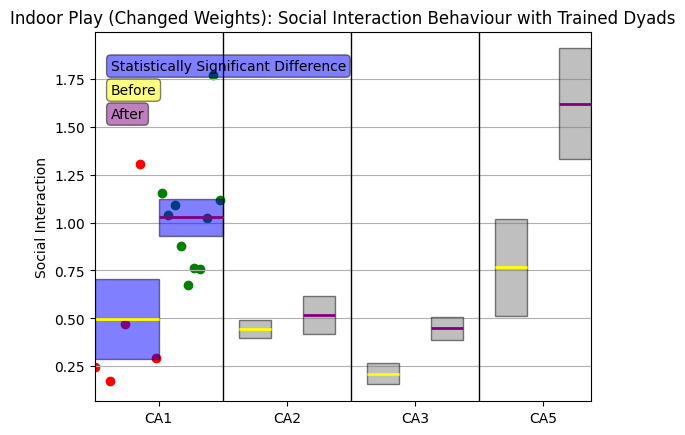

In [23]:
# get data points for graph: trained dyads indoor play social 
# before training
before_avg = []
before_err = []
for ca in ca_peer_list:
    statistics = get_ca_scenario_stats(
        filter_ca_scenario(
            get_trained_pair_files(), "so", "base", ca, "indoor"), "so")
    before_avg.append(statistics[0])
    before_err.append(statistics[2])

#print(before_avg)
#print(before_err)
# after training
after_avg = []
after_err = []
for ca in ca_peer_list:
    statistics = get_ca_scenario_stats(
        filter_ca_scenario(
            get_trained_pair_files(), "so", "inter", ca, "indoor"), "so")
    after_avg.append(statistics[0])
    after_err.append(statistics[2])
    
#print(after_avg)
#print(after_err)

# X-axis data for "before" and "after" measurements
x_before = np.array([1, 5, 9, 13])
x_after = np.array([3, 7, 11, 15])
x_midpoints = (x_before + x_after) / 2

# Box plots for "before" and "after" data
box_y_before = []
box_y_after = []
for i in range(len(before_avg)):
    point_before = []
    point_after = []
    point_before.append(before_avg[i] - 2*before_err[i])
    point_before.append(before_avg[i])
    point_before.append(before_avg[i] + 2*before_err[i])
    point_after.append(after_avg[i] - 2*after_err[i])
    point_after.append(after_avg[i])
    point_after.append(after_avg[i] + 2*after_err[i])
    
    box_y_before.append(point_before)
    box_y_after.append(point_after)


plt.boxplot(box_y_before[1::], positions=x_before[1::], whis=0, showfliers=False, 
            widths=1, patch_artist=True, showmeans=True, meanline=True, 
            meanprops=dict(color='yellow', linewidth=2, linestyle='-'), 
            boxprops=dict(facecolor='grey', alpha=0.5), #translucent boxes
            capprops={"linewidth": 0}) #remove cap lines
plt.boxplot(box_y_after[1::], positions=x_after[1::], whis=0, showfliers=False, 
            widths=1, patch_artist=True, showmeans=True, meanline=True, 
            meanprops=dict(color='purple', linewidth=2, linestyle='-'), 
            boxprops=dict(facecolor='grey', alpha=0.5), #translucent boxes
            capprops={"linewidth": 0}) #remove cap lines

# Change color for "CA1" data point
plt.boxplot(box_y_before[0], positions=[x_before[0]], whis=0, showfliers=False, 
            widths=2, patch_artist=True, showmeans=True, meanline=True, 
            meanprops=dict(color='yellow', linewidth=2, linestyle='-'), 
            boxprops=dict(facecolor='blue', alpha=0.5), #translucent boxes
            capprops={"linewidth": 0}) #remove cap lines
plt.boxplot(box_y_after[0], positions=[x_after[0]], whis=0, showfliers=False, 
            widths=2, patch_artist=True, showmeans=True, meanline=True, 
            meanprops=dict(color='purple', linewidth=2, linestyle='-'), 
            boxprops=dict(facecolor='blue', alpha=0.5), #translucent boxes
            capprops={"linewidth": 0}) #remove cap lines

y_values = get_ca_scenario_session_scores(filter_ca_scenario(
            get_trained_pair_files(), "so", "base", "albert", "indoor"), "so")
x_values = np.linspace(0, x_midpoints[0] - 0.1, len(y_values))
plt.scatter(x_values, y_values, color='red')
y_values2 = get_ca_scenario_session_scores(filter_ca_scenario(
            get_trained_pair_files(), "so", "inter", "albert", "indoor"), "so")
x_values2 = np.linspace(x_midpoints[0] + 0.1, 4 - 0.1, len(y_values2))
plt.scatter(x_values2, y_values2, color='green')

# Adding vertical lines to separate groups
for i in range(len(x_before) - 1):
    plt.axvline((x_before[i+1] + x_after[i]) /2, color='black', linestyle='-', linewidth=1)
    
# Adding labels and title
plt.ylabel('Social Interaction')
plt.title('Indoor Play (Changed Weights): Social Interaction Behaviour with Trained Dyads')

# Customizing x-axis ticks and labels
plt.xticks(x_midpoints, ['CA1', 'CA2', 'CA3', 'CA5'])

    
# Adding legend
plt.text(0.15, 0.8, "Statistically Significant Difference", bbox=dict(facecolor='blue', alpha=0.5, edgecolor='black', boxstyle='round,pad=0.3'), transform=plt.gcf().transFigure)
plt.text(0.15, 0.75, "Before", bbox=dict(facecolor='yellow', alpha=0.5, edgecolor='black', boxstyle='round,pad=0.3'), transform=plt.gcf().transFigure)
plt.text(0.15, 0.7, "After", bbox=dict(facecolor='purple', alpha=0.5, edgecolor='black', boxstyle='round,pad=0.3'), transform=plt.gcf().transFigure)

# Display the plot
plt.grid(axis='y')
plt.xlim(left=0)
plt.show()